<a href="https://colab.research.google.com/github/SuperTonik/Hobby/blob/main/MachineLearning/cnn_ct_image_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hemorrhage classifier using CNN
Work in progress.

In [6]:
import kagglehub
import os

# Download latest version
path = kagglehub.dataset_download("anmspro/head-ct-hemorrhage-128-x-128")

subfolder = os.listdir(path)
path = os.path.join(path, subfolder[0])
classes = os.listdir(path)
print("Path to dataset files:", path)
print(classes)

100%|██████████| 5.57M/5.57M [00:01<00:00, 4.32MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/anmspro/head-ct-hemorrhage-128-x-128/versions/1/head_ct (128x128)
['no hemorrhage', 'hemorrhage']


Loading data

In [121]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, random_split

device = torch.device("cuda" if torch.cuda.is_available else "cpu")
print(device)

my_transform = transforms.Compose(
    [transforms.ToTensor(),
      transforms.Normalize([0.5, 0.5, 0.5],
                           [0.5, 0.5, 0.5])])

full_dataset = ImageFolder(path, transform=my_transform)

train_size = int(0.7 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

cuda


Examining dataset

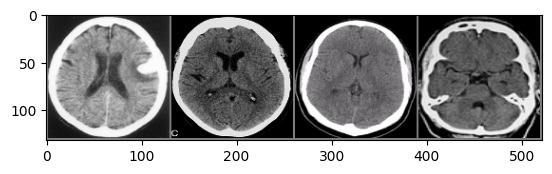

no hemorrhage, hemorrhage, hemorrhage, hemorrhage,


In [137]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
  # utility function for plotting images.
  # from pytorch docs.
  img = img / 2 + 0.5
  npimg = img.cpu().numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

data = next(iter(train_loader))
images, labels = data[0].to(device), data[1].to(device)
imshow(make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s},' for j in range(batch_size)))

In [138]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self, activation=F.relu):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 6, 3)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(13456, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 4)
    self.activation = activation

  def forward(self, x):
    x = self.pool(self.activation(self.conv1(x)))
    x = self.pool(self.activation(self.conv2(x)))
    x = torch.flatten(x, 1)
    x = self.activation(self.fc1(x))
    x = self.activation(self.fc2(x))
    x = self.fc3(x)
    return x

In [139]:
import torch.optim as optim

def fit_nn(net, train_loader, optimizer, criterion, epochs=5):
  for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
      inputs, labels = data[0].to(device), data[1].to(device)
      optimizer.zero_grad()
      outputs = net(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      if i % 20 == 19:
        print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 10:.3f}')
        running_loss = 0.0
  print("Training finished")

In [140]:
my_net = Net(activation=F.relu).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(my_net.parameters(), lr=0.001, momentum=0.9)

fit_nn(my_net, train_loader, optimizer, criterion)

[1,    20] loss: 2.698
[2,    20] loss: 1.603
[3,    20] loss: 1.394
[4,    20] loss: 1.395
[5,    20] loss: 1.310
Training finished


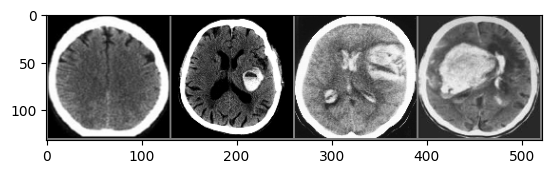

Correct classes: hemorrhage, no hemorrhage, no hemorrhage, no hemorrhage,
Predicted classes: hemorrhage, no hemorrhage, no hemorrhage, no hemorrhage,


In [141]:
data = next(iter(test_loader))
images, labels = data[0].to(device), data[1].to(device)
imshow(make_grid(images))
print('Correct classes:', ' '.join(f'{classes[labels[j]]:5s},' for j in range(batch_size)))

outputs = my_net(images)
_, predicted = torch.max(outputs, 1)
print('Predicted classes:', ' '.join(f'{classes[labels[j]]:5s},' for j in range(batch_size)))

In [142]:
def test_accuracy(net, test_loader):
  correct = 0
  total = 0
  with torch.no_grad():
    for data in test_loader:
      images, labels = data[0].to(device), data[1].to(device)
      outputs = net(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  print(f'Accuracy in test set ({total} images): {100 * correct // total} %')

test_accuracy(my_net, test_loader)

Accuracy in test set (40 images): 65 %


In [143]:
def test_class_accuracy(net, test_loader):
  correct_pred = {classname: 0 for classname in classes}
  total_pred = {classname: 0 for classname in classes}

  with torch.no_grad():
    for data in test_loader:
      images, labels = data[0].to(device), data[1].to(device)
      outputs = net(images)
      _, predictions = torch.max(outputs, 1)
      for label, prediction in zip(labels, predictions):
        if label == prediction:
          correct_pred[classes[label]] += 1
        total_pred[classes[label]] += 1

  for classname, count in correct_pred.items():
    print(f'Accuracy for class: {classname:5s} is {100 * count / total_pred[classname]:.1f}%')

test_class_accuracy(my_net, test_loader)

Accuracy for class: no hemorrhage is 95.0%
Accuracy for class: hemorrhage is 35.0%


In [144]:
net_leaky_relu = Net(activation=F.leaky_relu).to(device)
fit_nn(net_leaky_relu, train_loader, optimizer, criterion, 6)
test_accuracy(net_leaky_relu, test_loader)

[1,    20] loss: 2.743
[2,    20] loss: 2.741
[3,    20] loss: 2.737
[4,    20] loss: 2.744
[5,    20] loss: 2.747
[6,    20] loss: 2.741
Training finished
Accuracy in test set (40 images): 50 %


In [145]:
net_silu = Net(activation=F.silu).to(device)
fit_nn(net_silu, train_loader, optimizer, criterion, 6)
test_accuracy(net_silu, test_loader)

[1,    20] loss: 2.830
[2,    20] loss: 2.834
[3,    20] loss: 2.824
[4,    20] loss: 2.827
[5,    20] loss: 2.820
[6,    20] loss: 2.825
Training finished
Accuracy in test set (40 images): 0 %


In [155]:
net_relu_adam = Net(activation=F.relu).to(device)
optimizer = optim.Adam(net_relu_adam.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
fit_nn(net_relu_adam, train_loader, optimizer, criterion, 6)
test_accuracy(net_relu_adam, test_loader)
test_class_accuracy(net_relu_adam, test_loader)

[1,    20] loss: 1.535
[2,    20] loss: 1.122
[3,    20] loss: 0.808
[4,    20] loss: 0.812
[5,    20] loss: 0.588
[6,    20] loss: 0.457
Training finished
Accuracy in test set (40 images): 82 %
Accuracy for class: no hemorrhage is 70.0%
Accuracy for class: hemorrhage is 95.0%
